# MLP notes following Karpathy Makemore Part 2

The work follows the paper by [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## I want embedding size 3, context size 4 hidden layer size 200

In [1]:
# import all the usual suspects
import torch
import string
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('./names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
#a string of all the letters in an alphabet
alphabet = string.ascii_lowercase

al = ['.'] + list(alphabet)
print(al)

stoi = {a:i for i,a in enumerate(al)}
itos = {i:a for i,a in enumerate(al)}
len(stoi)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


27

In [37]:
block_size = 4

X, Y = [],[]
i = 1
for w in words[:6]:
    context = [0]*block_size
    for ch in w+'.': 
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print (i,"".join([itos [ci] for ci in context]),"--->",itos[ix])
        context= context[1:]+[ix]
        i += 1

X = torch.tensor(X)
Y = torch.tensor(Y)

1 .... ---> y
2 ...y ---> u
3 ..yu ---> h
4 .yuh ---> e
5 yuhe ---> n
6 uhen ---> g
7 heng ---> .
8 .... ---> d
9 ...d ---> i
10 ..di ---> o
11 .dio ---> n
12 dion ---> d
13 iond ---> r
14 ondr ---> e
15 ndre ---> .
16 .... ---> x
17 ...x ---> a
18 ..xa ---> v
19 .xav ---> i
20 xavi ---> e
21 avie ---> n
22 vien ---> .
23 .... ---> j
24 ...j ---> o
25 ..jo ---> r
26 .jor ---> i
27 jori ---> .
28 .... ---> j
29 ...j ---> u
30 ..ju ---> a
31 .jua ---> n
32 juan ---> l
33 uanl ---> u
34 anlu ---> i
35 nlui ---> s
36 luis ---> .
37 .... ---> e
38 ...e ---> r
39 ..er ---> a
40 .era ---> n
41 eran ---> d
42 rand ---> i
43 andi ---> .


In [15]:
X.shape

torch.Size([36, 4])

In [16]:
block_size = 4
def build_dataset(words):
    X, Y = [],[]

    for w in words:
        context = [0]*block_size
        for ch in w+".": 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print ("".join([itos [ci] for ci in context]),"--->",itos[ix])
            context= context[1:]+[ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y 

XX, YY = build_dataset(words[:8])

In [17]:
XX.shape

torch.Size([53, 4])

In [18]:
import random 
random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xts,Yts = build_dataset(words[n2:])

In [19]:
Xtr.shape, Xdev.shape, Xts.shape

(torch.Size([182625, 4]), torch.Size([22655, 4]), torch.Size([22866, 4]))

In [23]:
# Hyperparameters
vocab_size = 27 # alphabet including termination character '.' 
code_length = 5 # dimentionality of the character embedding vector

n_hidden = 300 # number of neuron in the hidden layer of the MLP



In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

#C = torch.randn((27,5),generator=g)
C = torch.randn((vocab_size,code_length),generator=g)

#W1 = torch.randn((20,300), generator=g) # code_length * block_size = 5 * 4 = 20, n_hidden = 300
W1 = torch.randn((code_length*block_size,n_hidden))

#b1 = torch.randn(300, generator=g)
b1 = torch.randn(n_hidden, generator=g)

#W2 = torch.randn((300,27),generator=g) *0.01 #output layer

W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
#b2 = torch.randn(27,generator=g) * 0 
b2 = torch.randn(vocab_size,generator=g) * 0 

params = [C,W1,b1,W2,b2]
for p in params:
  p.requires_grad = True

In [25]:
sum(p.nelement() for p in params)

14562

In [26]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [27]:
lri = []
lossi = []
stepi = []

In [28]:
ix = torch.randint(0, Xtr.shape[0], (64,))
emb = C[Xtr[ix]] 
emb.shape
h = torch.tanh(emb.view(-1, 20) @ W1 + b1) # (64, 200)
logits = h @ W2 + b2 # (64, 27)
loss = F.cross_entropy(logits, Ytr[ix])

print (f"{emb.shape=},{h.shape},{logits.shape=},{W2.shape}")
emb.shape
logits.shape
h.shape
W2.shape

emb.shape=torch.Size([64, 4, 5]),torch.Size([64, 300]),logits.shape=torch.Size([64, 27]),torch.Size([300, 27])


torch.Size([300, 27])

In [29]:
# backward pass
for p in params:
    p.grad = None
loss.backward()

In [30]:
  # update
  #lr = lrs[i]
lr = 0.1 
for p in params:
    p.data += -lr * p.grad

In [31]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))

  # forward pass
  emb = C[Xtr[ix]] # [64, 4, 3]
  h = torch.tanh(emb.view(-1, 20) @ W1 + b1) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


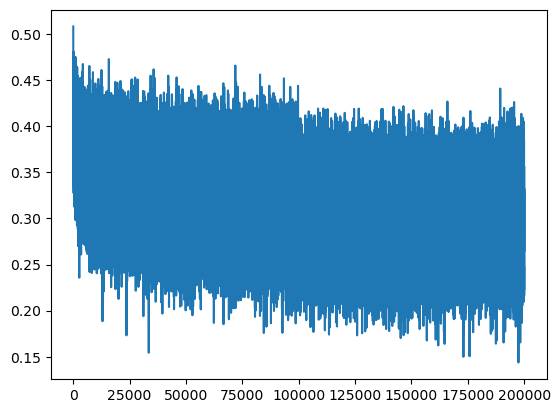

In [32]:
plt.plot(stepi, lossi)

In [34]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 20) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0133, grad_fn=<NllLossBackward0>)

In [35]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 20) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1017, grad_fn=<NllLossBackward0>)

In [36]:
emb = C[Xts] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 20) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yts)
loss

tensor(2.0938, grad_fn=<NllLossBackward0>)

In [39]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 1972)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

urleonon.
galino.
zyyas.
roap.
eliya.
isar.
sani.
heom.
nisa.
lexnee.
sharir.
jaislyanna.
richaeli.
fen.
dalynn.
novaraja.
gebal.
annan.
zarendar.
kostoni.


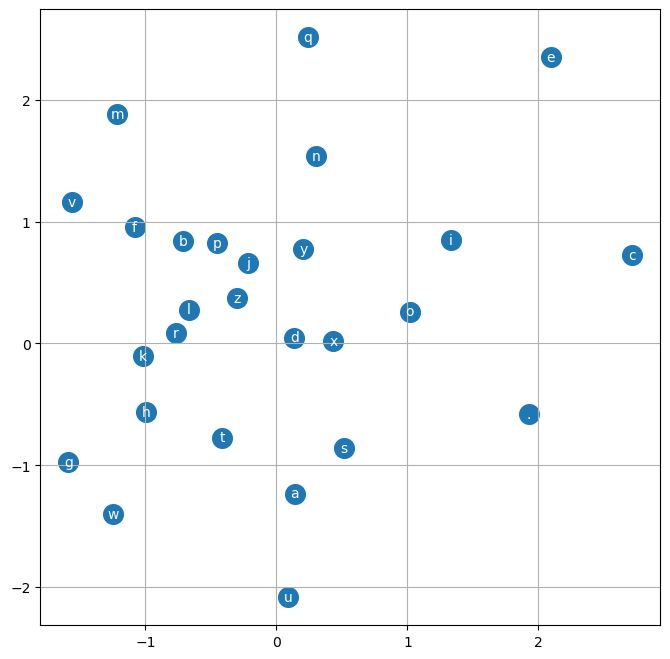

In [41]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [22]:
# import all the usual suspects
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [20]:
# height width

h,w = 4,4

s1 = np.zeros([h,w],dtype="int64")

for i in range(h):
    for j in range(w):
        s1[i,j] = np.random.choice([0, 1])
# s1 = np.ones([h,w]) - s1
s1

array([[0, 1, 0, 1],
       [1, 1, 0, 1],
       [0, 1, 1, 0],
       [1, 0, 0, 0]])

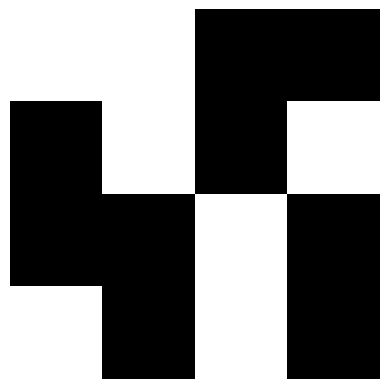

In [18]:
plt.imshow(s1, cmap='gray', vmin=0, vmax=1)
plt.axis('off')  # Optional: remove axis ticks
plt.show()


In [33]:
secret = np.zeros([h,w],dtype='int64')
secret[0,0] = 1
secret[0,1] = 1
secret[0,2] = 1
secret[1,1] = 1
secret[2,1] = 1



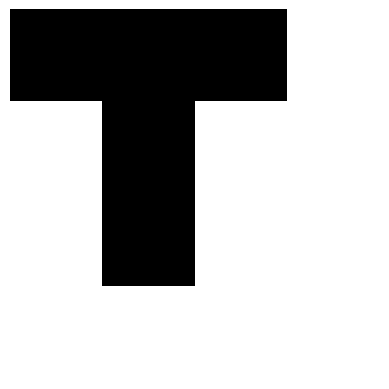

In [34]:
plt.imshow(np.ones([h,w])-secret, cmap='gray', vmin=0, vmax=1)
plt.axis('off')  # Optional: remove axis ticks
plt.show()

In [35]:
s2 = (s1 + secret) % 2 

In [36]:
s2

array([[1, 0, 1, 1],
       [1, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0]])

In [37]:
s1

array([[0, 1, 0, 1],
       [1, 1, 0, 1],
       [0, 1, 1, 0],
       [1, 0, 0, 0]])

In [38]:
secret

array([[1, 1, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0]])

In [56]:
# create visual secret share
def create_vss(s):
    z_pat = np.zeros([2,2])
    z_pat[0,1] = 1
    z_pat[1,0] = 1
    o_pat = np.zeros([2,2])
    o_pat[0,0] = 1
    o_pat[1,1] = 1

    A = np.zeros([s.shape[0]*2,s.shape[1]*2],dtype='int64')
    for i in range (s.shape[0]):
        for j in range (s.shape[1]):
            if s[i,j]==0:
                #copy 0 pattern
                A[i*2:i*2+2,j*2:j*2+2] = z_pat
            else:
                A[i*2:i*2+2,j*2:j*2+2] = o_pat
    return A

In [60]:


vss1 = create_vss(s1)
vss1

array([[0, 1, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 1, 1, 0],
       [0, 1, 0, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 1, 0, 1, 0, 1, 0]])

In [61]:
vss2 =  create_vss(s2)
vss2

array([[1, 0, 0, 1, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 1, 0, 1, 0, 1, 0]])

In [ ]:
def create_share_image(vss):
    pass


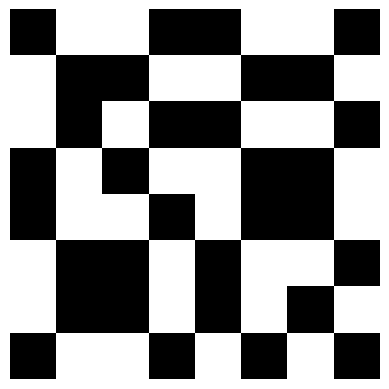

In [67]:
vss = vss1
rgba = np.zeros((vss.shape[0], vss.shape[1], 4))
rgba[vss == 0] = [0, 0, 0, 1]

plt.imshow(rgba)

plt.axis('off')
plt.imsave('share1.png', rgba)

plt.show()

In [ ]:
# Create a figure with specific size
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(rgba)
plt.axis('off')

# Save without extra padding or borders
plt.savefig('output_image.png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)